## Tennis Player Trajectories Analysis (2000–2024)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('preprocessed_tennis_data.csv', parse_dates=['date'])

# Inspect the first rows
data.head()


/var/folders/b9/w9wcjfgs11ng2m16_rw_zqlc0000gn/T/ipykernel_83169/1390164231.py:7: DtypeWarning: Columns (4,11,12,17,18,23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('preprocessed_tennis_data.csv', parse_dates=['date'])


,atp,location,tournament,date,series,court,surface,round,best_of,winner,...,lbw,lbl,psw,psl,tour,year,maxw,maxl,avgw,avgl
0,1.0,Adelaide,Next Generation Adelaide International,2007-12-31,International,Outdoor,Hard,1st Round,3.0,Querrey S.,...,1.533,2.375,1.667,2.400,ATP,2008,NaN,NaN,NaN,NaN
1,1.0,Adelaide,Next Generation Adelaide International,2007-12-31,International,Outdoor,Hard,1st Round,3.0,Sirianni J.,...,5.5,1.125,5.940,1.184,ATP,2008,NaN,NaN,NaN,NaN
2,1.0,Adelaide,Next Generation Adelaide International,2007-12-31,International,Outdoor,Hard,1st Round,3.0,Russell M.,...,3.4,1.300,3.550,1.364,ATP,2008,NaN,NaN,NaN,NaN
3,1.0,Adelaide,Next Generation Adelaide International,2007-12-31,International,Outdoor,Hard,1st Round,3.0,Becker B.,...,1.4,2.750,1.538,2.760,ATP,2008,NaN,NaN,NaN,NaN
4,1.0,Adelaide,Next Generation Adelaide International,2007-12-31,International,Outdoor,Hard,1st Round,3.0,Zverev M.,...,1.909,1.800,1.893,2.020,ATP,2008,NaN,NaN,NaN,NaN


In [4]:
# Convert rankings and points to numeric (handle invalid entries)
numeric_cols = ['wrank', 'lrank', 'wpts', 'lpts']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Remove rows where ranks are NaN (optional, depends on analysis)
data_clean = data.dropna(subset=['wrank', 'lrank'])


In [5]:
# Select elite players (those who've ever ranked Top 10)
elite_winners = data_clean.loc[data_clean['wrank'] <= 10, 'winner'].unique()
elite_losers = data_clean.loc[data_clean['lrank'] <= 10, 'loser'].unique()

elite_players = set(elite_winners).union(elite_losers)
print(f"Total elite players identified: {len(elite_players)}")


Total elite players identified: 182


In [6]:
def player_data(df, player_col, rank_col, points_col, result_label):
    df_temp = df[['date', 'tournament', 'surface', 'round', player_col, rank_col, points_col]].copy()
    df_temp.columns = ['date', 'tournament', 'surface', 'round', 'player', 'rank', 'points']
    df_temp['result'] = result_label
    return df_temp

# Combine winner and loser data
winners_df = player_data(data_clean, 'winner', 'wrank', 'wpts', 'Win')
losers_df = player_data(data_clean, 'loser', 'lrank', 'lpts', 'Loss')

players_df = pd.concat([winners_df, losers_df]).sort_values(by=['player', 'date']).reset_index(drop=True)
players_df.head()


,date,tournament,surface,round,player,rank,points,result
0,2006-09-26,Campionati Internazionali Di Sicilia,Clay,1st Round,Hajek J.,79.0,506.0,Win
1,2006-09-28,Campionati Internazionali Di Sicilia,Clay,2nd Round,Hajek J.,79.0,506.0,Loss
2,2014-07-28,Citi Open,Hard,1st Round,Abanda F.,214.0,269.0,Loss
3,2014-08-04,Rogers Cup,Hard,1st Round,Abanda F.,209.0,269.0,Loss
4,2014-08-25,US Open,Hard,1st Round,Abanda F.,205.0,269.0,Loss


In [7]:
# Keep only elite players
elite_df = players_df[players_df['player'].isin(elite_players)].copy()
print(f"{elite_df['player'].nunique()} elite players found.")


182 elite players found.


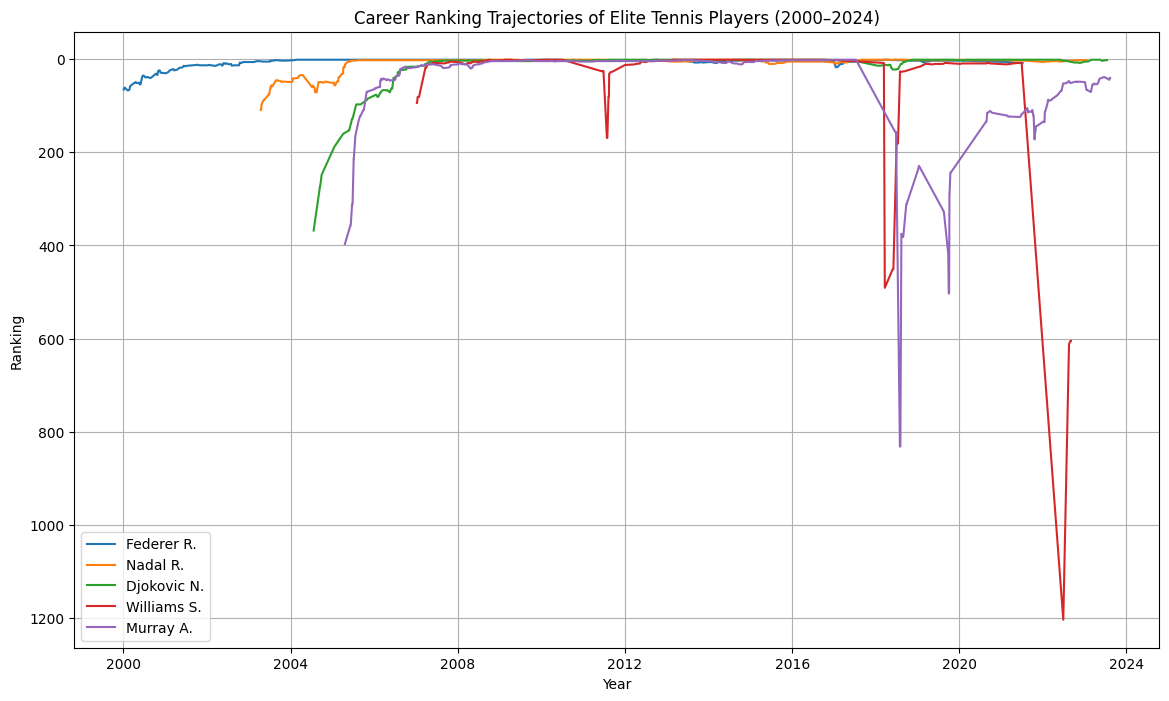

In [8]:
# Example elite players to visualize
top_players = ['Federer R.', 'Nadal R.', 'Djokovic N.', 'Williams S.', 'Murray A.']

plt.figure(figsize=(14, 8))
for player in top_players:
    player_history = elite_df[elite_df['player'] == player]
    plt.plot(player_history['date'], player_history['rank'], label=player)

plt.gca().invert_yaxis()  # Lower rank = better performance
plt.xlabel('Year')
plt.ylabel('Ranking')
plt.title('Career Ranking Trajectories of Elite Tennis Players (2000–2024)')
plt.legend()
plt.grid()
plt.show()


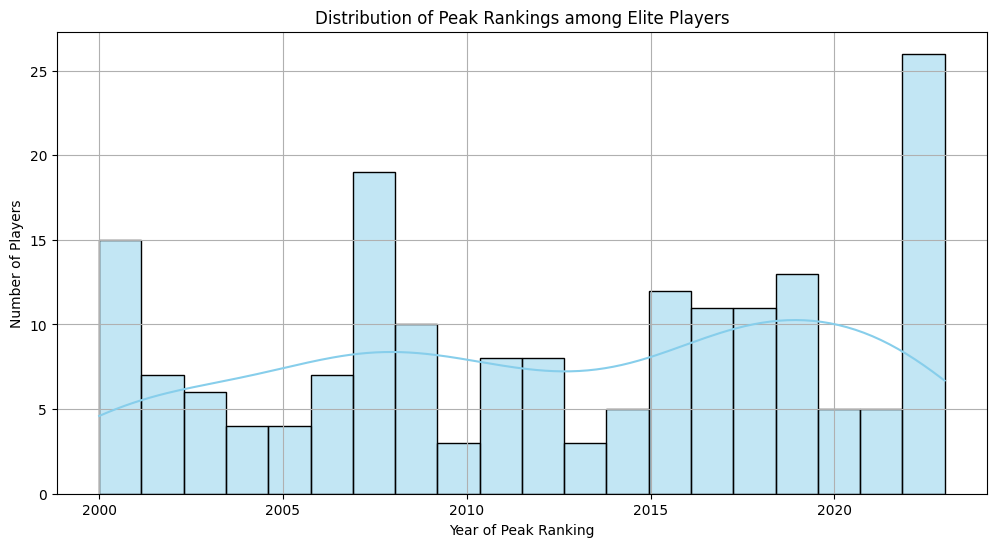

In [9]:
# Identify each elite player's peak rank
peak_ranks = elite_df.loc[elite_df.groupby('player')['rank'].idxmin()]

# Peak rank distribution over years
plt.figure(figsize=(12,6))
sns.histplot(peak_ranks['date'].dt.year, bins=20, kde=True, color='skyblue')
plt.xlabel('Year of Peak Ranking')
plt.ylabel('Number of Players')
plt.title('Distribution of Peak Rankings among Elite Players')
plt.grid()
plt.show()


In [10]:
# Career statistics calculation
career_metrics = elite_df.groupby('player').agg({
    'rank': ['mean', 'std', 'min'],
    'points': 'mean',
    'result': lambda x: (x == 'Win').mean()
}).dropna()

career_metrics.columns = ['avg_rank', 'rank_volatility', 'best_rank', 'avg_points', 'win_rate']

# Perform KMeans clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(career_metrics)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
career_metrics['cluster'] = kmeans.fit_predict(metrics_scaled)

career_metrics.head()


,avg_rank,rank_volatility,best_rank,avg_points,win_rate,cluster
player,,,,,,
Agassi A.,5.399433,4.887565,1.0,8510.368272,0.759207,1
Alcaraz C.,31.808383,57.616820,1.0,4185.970060,0.790419,1
Almagro N.,39.574695,42.376112,9.0,1755.992378,0.586890,0
Ancic M.,52.121019,77.061973,9.0,4470.735669,0.608280,0
Anderson K.,42.755853,48.625054,5.0,1611.501672,0.580268,0


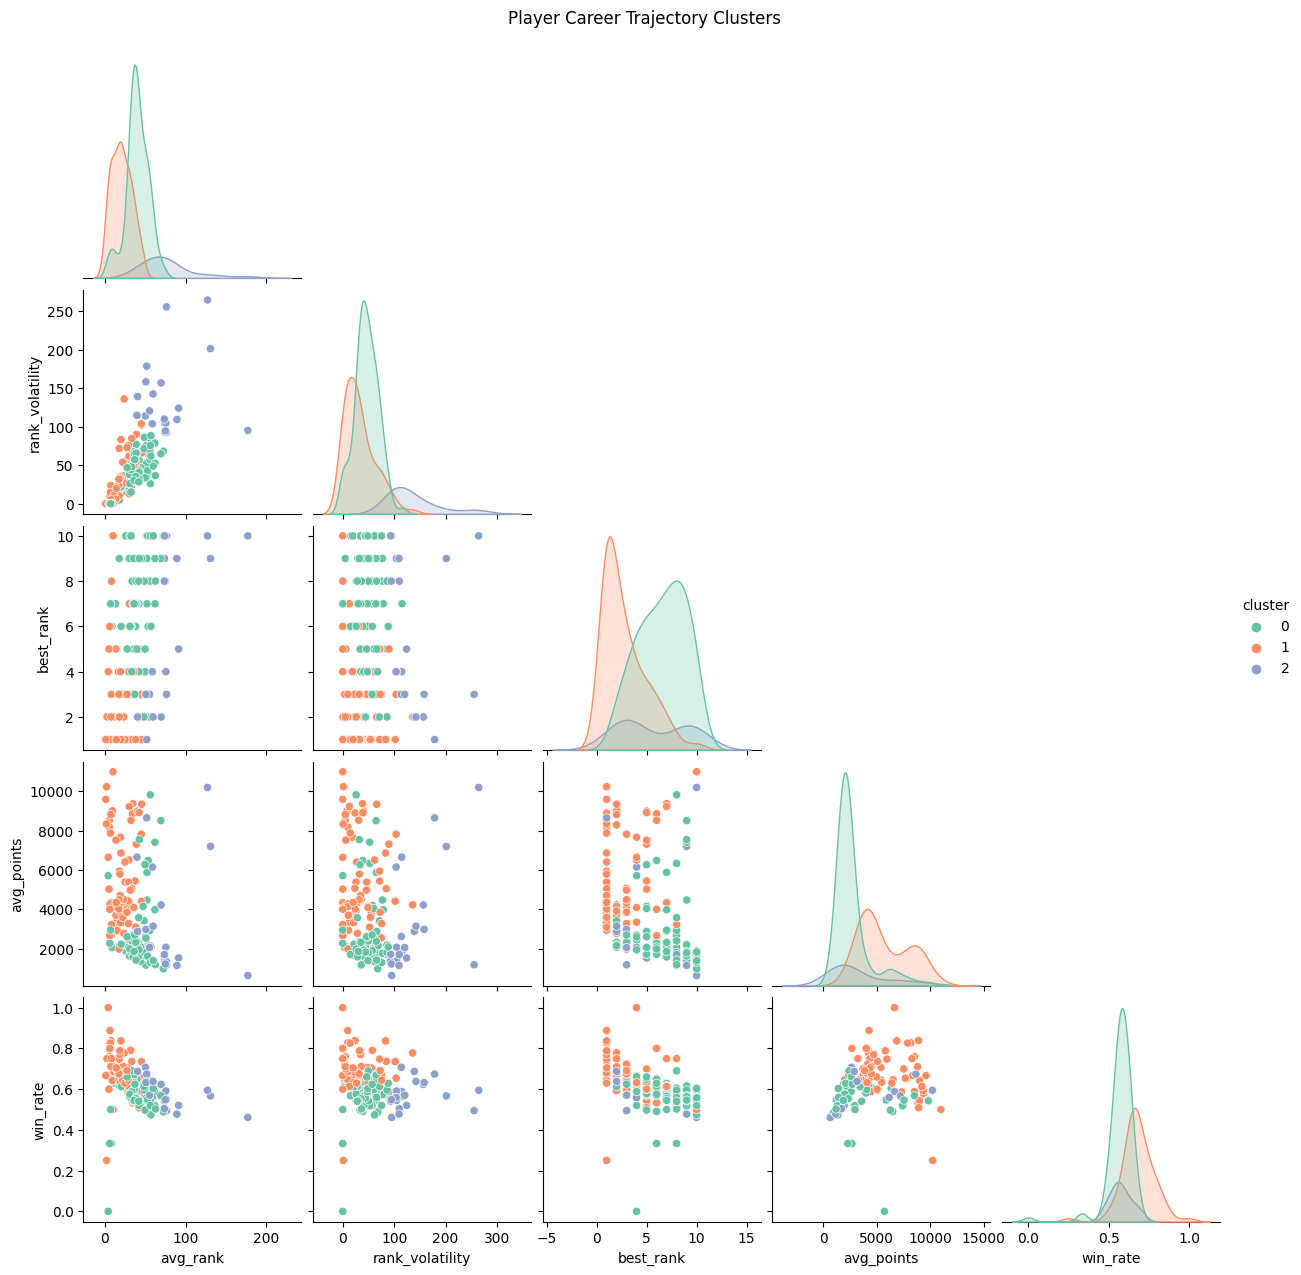

In [11]:
sns.pairplot(career_metrics, hue='cluster', palette='Set2', corner=True)
plt.suptitle('Player Career Trajectory Clusters', y=1.02)
plt.show()
